# Exponential Smoothing Exercise

## PSMA 2020

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_absolute_error
from forecast.baseline import Naive1

## Simple Exponential Smoothing

### Step by Step Worked Example of using SES

**Step 1.1. Read the data into a pandas DataFrame**

The first thing we will do is read in the data from the file `Nile.csv`

To do this we will call the method:

```python 
pd.read_csv()
```

 
Remember that you need to pass in three keyword arguments.
* filepath_or_buffer - e.g. is the directory/filename.csv
* index_col - the name of the column that contains the date/time information
* parse_dates = True



In [2]:
#read in Nile Data
nile = pd.read_csv('data/nile.csv', index_col='year', parse_dates=True)

In [3]:
#how manay observations in the time series?
nile.shape

(60, 1)

In [4]:
#let's have a look at the first 5 observations
nile.head(5)

,flow
year,
1871-01-01,3533.916667
1872-01-01,3664.250000
1873-01-01,3047.500000
1874-01-01,3808.583333
1875-01-01,3677.500000


**Step 1.2: Set the frequency of the data**
  
When you read datetime data in from file it is always worth checking that pandas has set the frequency correctly.  Let's have a look this for the nile data.

In [5]:
nile.index

DatetimeIndex(['1871-01-01', '1872-01-01', '1873-01-01', '1874-01-01',
               '1875-01-01', '1876-01-01', '1877-01-01', '1878-01-01',
               '1879-01-01', '1880-01-01', '1881-01-01', '1882-01-01',
               '1883-01-01', '1884-01-01', '1885-01-01', '1886-01-01',
               '1887-01-01', '1888-01-01', '1889-01-01', '1890-01-01',
               '1891-01-01', '1892-01-01', '1893-01-01', '1894-01-01',
               '1895-01-01', '1896-01-01', '1897-01-01', '1898-01-01',
               '1899-01-01', '1900-01-01', '1901-01-01', '1902-01-01',
               '1903-01-01', '1904-01-01', '1905-01-01', '1906-01-01',
               '1907-01-01', '1908-01-01', '1909-01-01', '1910-01-01',
               '1911-01-01', '1912-01-01', '1913-01-01', '1914-01-01',
               '1915-01-01', '1916-01-01', '1917-01-01', '1918-01-01',
               '1919-01-01', '1920-01-01', '1921-01-01', '1922-01-01',
               '1923-01-01', '1924-01-01', '1925-01-01', '1926-01-01',
      

This shows that the frequency of the datetimeindex is set to None.  We need to set this to the correct frequency in order to for the statsmodels Exponential Smoothing methods to work correctly.  In this case we have annual data.  We are going to use the frequency 'AS' which starts for Annual Start.

In [6]:
nile.index.freq = "AS"

**Step 1.3. Train-Test Split**

We are going to hold back the final 10 observations and attempt to predict them using SES

In [7]:
HOLDOUT_OBS = 10
train, test = nile.iloc[:-HOLDOUT_OBS:], nile.iloc[-HOLDOUT_OBS:]

In [8]:
#we should have 60 - HOLDOUT_OBS data points for training
train.shape

(50, 1)

In [9]:
#we should have HOLDOUT_OBS data points for testing
test.shape

(10, 1)

**Step 1.4. Visualise the data**

The easiest way to do this is to call the `.plot()` method of the `DataFrame`

In [10]:
train['flow'].plot(figsize=(12,4));

**Step 1.6. Create a simple baseline model**

It is unclear if there is a trend or seasonality in the nile time series.  This is also annual data which does not offer an obvious period for seasonality like monthly or quarterly data.  Before we use SES it is a good idea to use a Naive Forecast to set a baseline.  We will follow this up with use Simple Exponential Smoothing as that is suitable for data without trend or seasonality

In [11]:
nf1 = Naive1()
nf1.fit(train['flow'])
nf1_preds = nf1.predict(10)
nf1_mae = mean_absolute_error(y_true=test['flow'], y_pred=nf1_preds)
print(f'NF1 MAE {nf1_mae:.2f}')

NF1 MAE 236.41


In [12]:
def plot_naive_forecast(train, test, fitted_model, horizon):

    #plot the fitted values and prediction
    ax = train.plot(figsize=(12,4))
    
    preds = fitted_model.predict(horizon)
    intervals = pd.DataFrame(fitted_model.prediction_interval(horizon, [0.8])[0], index=test.index)
    intervals.columns = ['lower', 'upper']

    ax.fill_between(intervals.index,intervals['lower'], intervals['upper'], 
                    alpha=0.5,
                    label='80% PI');

    pd.DataFrame(preds, index=test.index).plot(ax=ax, label='forecast', color='red');

    fitted_model.fittedvalues.plot(ax=ax, label='fitted', color='green', linestyle='--')

    ax.legend(['train', 'forecast', 'fitted', '80% PI'],loc=3);

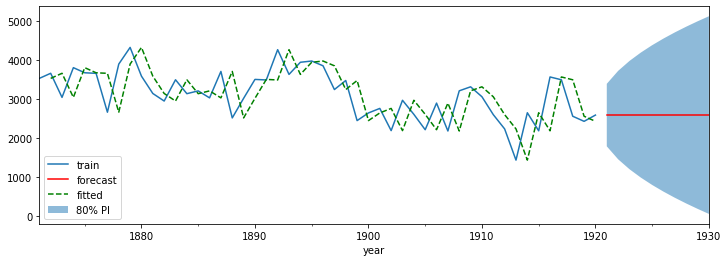

In [13]:
plot_naive_forecast(train['flow'], test['flow'], nf1, 10)

**Step 1.6. Create an instance of an `ExponentialSmoothing` object for SES**

In [14]:
#for SES pass in the endog argument as your data - that's it!
model_ses = ExponentialSmoothing(endog=train['flow'])

**Step 1.7. Fit the model to the training data**

Before we can forecast, we first need to fit the model to the data in order to estimate the smoothing parameter $\alpha$.  To do this you need to call the `.fit()` method of the model.

In [15]:
results_ses = model_ses.fit()

**Step 1.8. Forecast!**

With an `ExponentialSmoothing` object for SES you need to call two methods to get the forecast and prediction intervals.


In [16]:
#a variable to store how far ahead we will forecast
#in this case 10 years of nile flow.
HORIZON=10  

#the create the forecast call the get_forecast method like so.
#the method returns a results object that contains your forecasts.
forecast = results_ses.get_forecast(steps=HORIZON)

In [17]:
#the forecast.summary_frame() method returns a pandas data frame.
#here alpha refers to alpha for a prediction interval 0.2 = 80% pred interval.
#make sure you don't confuse this alpha with the SES smoothing parameter!
forecast.summary_frame(alpha=0.2)

flow,mean,mean_se,mean_ci_lower,mean_ci_upper
1921-01-01,2672.965892,537.219297,1984.491661,3361.440123
1922-01-01,2672.965892,565.046204,1948.830045,3397.101739
1923-01-01,2672.965892,591.565594,1914.844079,3431.087704
1924-01-01,2672.965892,616.946100,1882.317651,3463.614133
1925-01-01,2672.965892,641.322953,1851.077458,3494.854326
1926-01-01,2672.965892,664.806565,1820.981998,3524.949786
1927-01-01,2672.965892,687.488479,1791.913956,3554.017828
1928-01-01,2672.965892,709.445592,1763.774783,3582.157001
1929-01-01,2672.965892,730.743243,1736.480745,3609.451039
1930-01-01,2672.965892,751.437506,1709.959979,3635.971805


The dataframe contains your 10 step forecast.  For each time horizon you have the information on the forecast distribution.  It's mean (which is a constant level in Simple Exponential Smoothing), the standard error of the mean at that step and the lower and upper prediction intervals.

**Step 1.9. Plot the forecast**

The matplotlib code to plot the forecast has been provided for you. 

In [18]:
def plot_ses_forecast(ts, fitted_values, forecast):

    #plot the fitted values and prediction
    ax = ts.plot(figsize=(12,4))
    forecast_80 = forecast.summary_frame(alpha=0.2)[['mean', 'mean_ci_lower', 'mean_ci_upper']]
    forecast_90 = forecast.summary_frame(alpha=0.1)[['mean', 'mean_ci_lower', 'mean_ci_upper']]


    ax.fill_between(forecast_90.index,forecast_90['mean_ci_lower'], forecast_90['mean_ci_upper'], 
                    alpha=0.5,
                    label='90% PI');

    ax.fill_between(forecast_80.index,forecast_80['mean_ci_lower'], forecast_80['mean_ci_upper'], 
                    alpha=0.5,
                    label='80% PI');

    forecast_80['mean'].plot(ax=ax, label='forecast', color='red');

    fitted_values.plot(ax=ax, label='fitted', color='green', linestyle='--')

    ax.legend(loc=3);

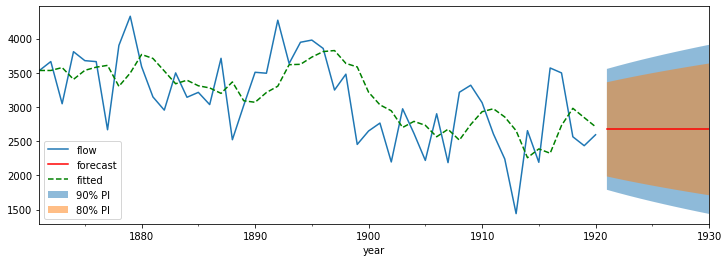

In [19]:
plot_ses_forecast(train['flow'], results_ses.fittedvalues, forecast)

**Step 1.10 Evaluate forecast accuracy**

The first thing to do is to compare the Mean Absolute Error of the Naive forecast and SES

In [20]:
#calculate the MAEs for each model.
ses_mae = mean_absolute_error(y_true=test['flow'], y_pred=forecast.summary_frame()['mean'])
nf1_mae = mean_absolute_error(y_true=test['flow'], y_pred=nf1_preds)

In [21]:
#print them out
print(f'NF1 MAE: {nf1_mae:.2f}')
print(f'SES MAE: {ses_mae:.2f}')

NF1 MAE: 236.41
SES MAE: 237.82


For point forecasts there is little difference between the two models.

What about prediction intervals?  Let's judge that visually by plotting them side by side.

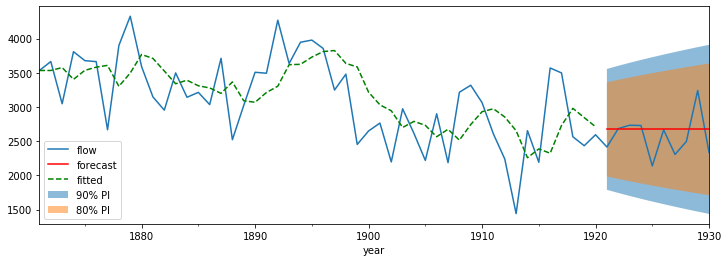

In [22]:
plot_ses_forecast(nile['flow'], results_ses.fittedvalues, forecast)

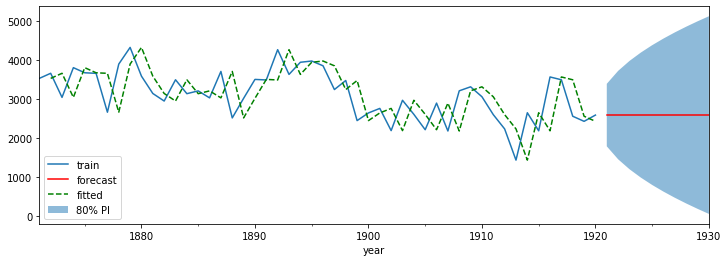

In [23]:
plot_naive_forecast(train['flow'], test['flow'], nf1, HORIZON)

**Important questions to think about on your own**
* What do you think of the forecasts of the two methods? Which method would you choose?
* Which model was most uncertain in its predictions? How could you tell?
* Which model had the most useful prediction intervals?
* Are there any issues with the prediction intervals of your chosen model?  What would make them more useful?

### **Here is the full code listing for the SES example**

NF1 MAE: 236.41
SES MAE: 237.82


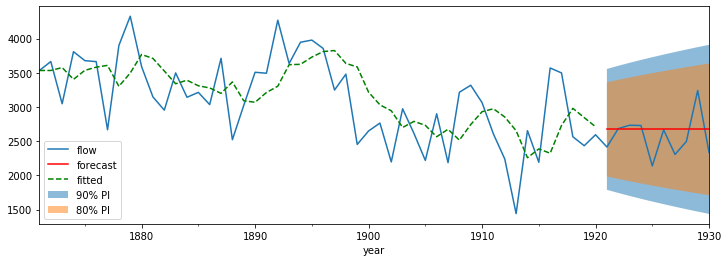

In [24]:
#read in Nile Data
nile = pd.read_csv('data/nile.csv', index_col='year', parse_dates=True)
nile.index.freq = "AS"

#train-test split
HOLDOUT_OBS = 10
train, test = nile.iloc[:-HOLDOUT_OBS:], nile.iloc[-HOLDOUT_OBS:]

#baseline model
HORIZON=10  
nf1 = Naive1()
nf1.fit(train['flow'])
nf1_preds = nf1.predict(10)
nf1_mae = mean_absolute_error(y_true=test['flow'], y_pred=nf1_preds)

#for SES pass in the endog argument as your data - that's it!
model_ses = ExponentialSmoothing(endog=train['flow'])
results_ses = model_ses.fit()

#the create the forecast call the get_forecast method like so.
#the method returns a results object that contains your forecasts.
forecast = results_ses.get_forecast(steps=HORIZON)

#calculate the MAEs for each model.
ses_mae = mean_absolute_error(y_true=test['flow'], y_pred=forecast.summary_frame()['mean'])
nf1_mae = mean_absolute_error(y_true=test['flow'], y_pred=nf1_preds)

#print them out
print(f'NF1 MAE: {nf1_mae:.2f}')
print(f'SES MAE: {ses_mae:.2f}')

#plot SES
ax = plot_ses_forecast(nile['flow'], results_ses.fittedvalues, forecast)

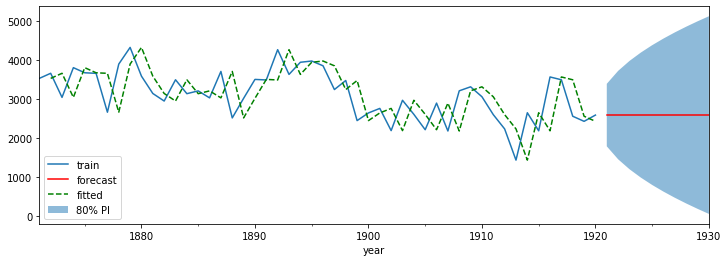

In [25]:
#plot naive
plot_naive_forecast(train['flow'], test['flow'], nf1, HORIZON)

### Exponential Smoothing Exercise

We will be using national NHS data that represents the monthly total number of patients that reattend an ED within 7 days of their initial visit.

The data are stored in the file `ed_reattend.csv`.  The data and a train-test split has been completed for you.  Your task is to follow the prescribed steps to forecast 12 months ahead.

In [60]:
#Step 1: read in reattends data ans set the frequency
ed = pd.read_csv('data/ed_reattend.csv', index_col='date', parse_dates=True, dayfirst=True)
ed.index.freq = 'MS'
ed['reattends'] = ed['reattends'] / ed.index.days_in_month

**Step 2: Train - Test Split**

In [61]:
HOLDOUT_SIZE = 12
train, test = ed[:-HOLDOUT_SIZE], ed[-HOLDOUT_SIZE:]

In [62]:
train.shape

(39, 1)

In [63]:
test.shape

(12, 1)

**Step 3: Plot the training data**

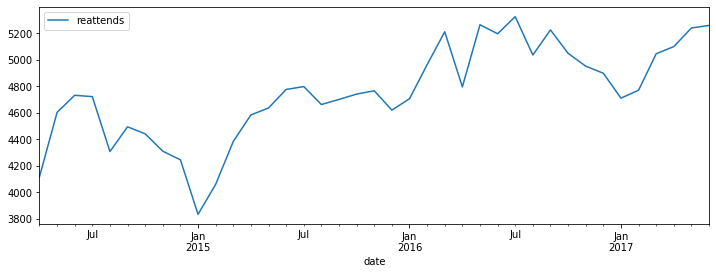

In [64]:
##your code here...
train.plot(figsize=(12,4))

**Step 4. Create a baseline forecast using Drift**

In [65]:
from forecast.baseline import Drift

In [66]:
HORIZON = 12
nf = Drift()
nf.fit(train['reattends'])
nf_preds = nf.predict(HORIZON)


**Step 5. Plot the naive forecast**

Remember that you can use the plot_naive_forecast function from the previous example.

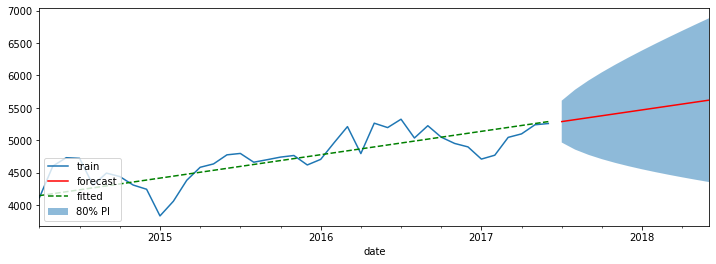

In [67]:
plot_naive_forecast(train['reattends'], test['reattends'], nf, HORIZON)

**Step 6. Calculate the Mean absolute error of the naive forecast**

In [68]:
mean_absolute_error(y_true = test['reattends'], y_pred=nf_preds)

306.54928955453175

**Step 7. Create two candidate forcasting models.**~

* model 1 =  Exponential Smoothing with Additive Trend. (hint use the `trend` parameter)
* model 2 =  Expeonential Snoothing with Damped Trend. (hint: use the `damped_trend` parameter)

In [72]:
test['reattends']

date
2017-07-01    5326.483871
2017-08-01    4981.000000
2017-09-01    5180.000000
2017-10-01    5226.677419
2017-11-01    5116.633333
2017-12-01    4906.032258
2018-01-01    4911.032258
2018-02-01    5017.321429
2018-03-01    5116.225806
2018-04-01    5220.100000
2018-05-01    5428.903226
2018-06-01    5413.833333
Freq: MS, Name: reattends, dtype: float64

In [75]:
#for SES pass in the endog argument as your data - that's it!
model_trend = ExponentialSmoothing(endog=ed['reattends'])
#model_damped = ExponentialSmoothing(endog=train['reattends'], trend=True, damped_trend=True)

In [78]:
results_trend = model_trend.fit(train['reattends'])
#results_damped = model_damped.fit(train['reattends'])

/home/tom/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/exponential_smoothing.py:392: RuntimeWarning: invalid value encountered in log
  unconstrained[0] = np.log(tmp / (1 - tmp))
/home/tom/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [77]:
forecast_trend = results_trend.get_forecast(steps=HORIZON)
forecast_trend.summary_frame(alpha=0.2)

reattends,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-07-01,NaN,NaN,NaN,NaN
2018-08-01,NaN,NaN,NaN,NaN
2018-09-01,NaN,NaN,NaN,NaN
2018-10-01,NaN,NaN,NaN,NaN
2018-11-01,NaN,NaN,NaN,NaN
2018-12-01,NaN,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN
2019-02-01,NaN,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN,NaN


In [38]:
train['reattends']

date
2014-04-01    123524
2014-05-01    142701
2014-06-01    141965
2014-07-01    146389
2014-08-01    133552
2014-09-01    134840
2014-10-01    137694
2014-11-01    129322
2014-12-01    131624
2015-01-01    118884
2015-02-01    113708
2015-03-01    135917
2015-04-01    137528
2015-05-01    143733
2015-06-01    143287
2015-07-01    148736
2015-08-01    144541
2015-09-01    141033
2015-10-01    146980
2015-11-01    142983
2015-12-01    143229
2016-01-01    145901
2016-02-01    143916
2016-03-01    161550
2016-04-01    143870
2016-05-01    163187
2016-06-01    155888
2016-07-01    165079
2016-08-01    156111
2016-09-01    156751
2016-10-01    156512
2016-11-01    148560
2016-12-01    151851
2017-01-01    146032
2017-02-01    133571
2017-03-01    156406
2017-04-01    152982
2017-05-01    162430
2017-06-01    157762
Freq: MS, Name: reattends, dtype: int64